In [58]:
import numpy as np
import random

def select_keyframes(image_list, num_frames=10, seed=42):
    return [image_list[2]] if image_list else []


In [59]:
def write_tracking_pairs(keyframes, non_keyframes, output_path="outputs/pairs_tracking.txt"):
    with open(output_path, "w") as f:
        for kf in keyframes:
            for img in non_keyframes:
                f.write(f"{kf} {img}\n")
    print(f"Saved tracking pairs to {output_path}")

In [60]:
from read_bin import parse_colmap

pairs, image_list, point_list, extrinsic, intrinsics = parse_colmap("output/sparse/0")

Camera: [403.91298213 256.         192.        ]
Camera: [392.62331998 256.         192.        ]
Camera: [387.8070045 256.        192.       ]
Camera: [401.01983473 256.         192.        ]
Camera: [390.42860693 256.         192.        ]
Camera: [391.69270167 256.         192.        ]
Camera: [376.64577487 256.         192.        ]
Camera: [392.29399854 256.         192.        ]
Camera: [402.34741317 256.         192.        ]
Camera: [387.32386582 256.         192.        ]
Camera: [387.15257138 256.         192.        ]
Camera: [393.14427777 256.         192.        ]
Camera: [377.09468105 256.         192.        ]


In [61]:
# print("point_list:", point_list)
# print(point_list[6568])

In [62]:
# print("intrinsics:", intrinsics)

In [63]:
keyframe_names = select_keyframes(image_list, num_frames=1, seed=42)
non_keyframes = [img for img in image_list if img not in keyframe_names]
write_tracking_pairs(keyframe_names, non_keyframes, output_path="outputs/pairs_tracking.txt")

try:
    key_frame_idx = image_list.index(keyframe_names[0])
except ValueError:
    print(f"{keyframe_names[0]} not found in image_list!")
print(f"Keyframe: {keyframe_names[0]}, ID: {key_frame_idx}")

Saved tracking pairs to outputs/pairs_tracking.txt
Keyframe: Frame_1752801091640.jpg, ID: 2


In [64]:
features = pairs[key_frame_idx]
prev_pts = np.array([f[0] for f in features], dtype=np.float32).reshape(-1, 1, 2)
# prev_pts

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
key_frame_name = image_list[key_frame_idx]
keyframe_path = f"data/images/{key_frame_name}"
print("Keyframe path:", keyframe_path)
prev_img = cv2.imread(keyframe_path, cv2.IMREAD_GRAYSCALE)
h, w = prev_img.shape
R1, t1 = extrinsic[key_frame_idx]
print("R :",R1)
print("T :",t1)
pair = pairs[key_frame_idx]
# print("pair :", pair)
point_ids = [pid for (_, pid) in pair]
# print("points :", point_ids)
pts3d = [point_list[pid] for pid in point_ids if pid in point_list]
# print("Matched 3D points:", pts3d)


Keyframe path: data/images/Frame_1752801091640.jpg
R : [[ 0.77332064 -0.23613733  0.58839982]
 [ 0.35311739 -0.61037366 -0.70905014]
 [ 0.52657696  0.75609732 -0.38863036]]
T : [-0.38405127  0.51421361  0.955116  ]


In [66]:
N = 500
random.seed(42)  # 為了可重現，固定亂數種子
sample_indices = random.sample(range(len(point_ids)), N)

# 挑出 point_id、其對應的 3D 點、以及 影像上的 2D 點
sampled_point_ids = [point_ids[i] for i in sample_indices]
sampled_3d_points = [point_list[pid] for pid in sampled_point_ids]

# 對應的影像座標點 (xys) 是 pairs 中的 index 0 欄位
sampled_2d_points = [pair[i][0] for i in sample_indices]

# print("選到的 3D point IDs:", sampled_point_ids)
# print("對應的 3D 座標:")
# for pt in sampled_3d_points:
#     print(pt)
# print("對應的 keyframe 上 2D 特徵點座標:")
# for pt in sampled_2d_points:
#     print(pt)


pts3d = np.array(sampled_3d_points)

In [67]:
print(image_list)

['Frame_1752801061758.jpg', 'Frame_1752801086639.jpg', 'Frame_1752801091640.jpg', 'Frame_1752801095438.jpg', 'Frame_1752801081073.jpg', 'Frame_1752801099504.jpg', 'Frame_1752801077422.jpg', 'Frame_1752801049524.jpg', 'Frame_1752801073923.jpg', 'Frame_1752801054408.jpg', 'Frame_1752801065840.jpg', 'Frame_1752801069240.jpg', 'Frame_1752801058791.jpg']


In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def project_and_visualize_points(
    name,                # 圖片名稱（不含路徑）
    target_frame_idx,       # 關鍵幀 index，用來取 intrinsics
    extrinsic,        # 所有相機姿態 dict：idx → (R, t)
    intrinsics,          # 相機內參 dict：idx → K
    pts3d,               # 3D 點 list 或 np.array
    image_shape,         # 圖像尺寸 (h, w)，用於邊界檢查
    img_root="data/images",  # 圖像資料夾路徑
    color_image=None,
    visualize=True       # 是否顯示圖像
):
    h, w = image_shape
    img_path = f"{img_root}/{name}"
    
    if color_image is not None:
        curr_img = color_image
    else:
        curr_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if curr_img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    R, t = extrinsic[target_frame_idx]
    K = intrinsics[target_frame_idx]

    pts3d_np = np.asarray(pts3d)
    pts_cam = (R @ pts3d_np.T + t.reshape(3, 1)).T  # shape (N, 3)

    pts_proj = (K @ pts_cam.T).T  # shape (N, 3)
    pts_proj /= pts_proj[:, 2:3]  # normalize by z

    point_colors = []
    if color_image is not None:
        vis_img = curr_img.copy()
        for pt2d in pts_proj[:, :2]:
            x, y = int(round(pt2d[0])), int(round(pt2d[1]))
            if 0 <= x < w and 0 <= y < h:
                color = curr_img[y, x]  # shape: (3,) in BGR
                point_colors.append(color[::-1])  # Convert BGR to RGB
                if visualize:
                    cv2.circle(vis_img, (x, y), 2, (0, 255, 0), -1)
            else:
                point_colors.append(np.array([0, 0, 0]))  # fallback color if out of bounds

    if visualize:
        vis_img = cv2.cvtColor(curr_img, cv2.COLOR_GRAY2BGR)
        for x, y in pts_proj[:, :2].astype(int):
            if 0 <= x < w and 0 <= y < h:
                cv2.circle(vis_img, (x, y), 2, (0, 255, 0), -1)

        plt.figure(figsize=(10, 6))
        plt.imshow(vis_img[..., ::-1])  # BGR to RGB
        plt.title(f"Projection onto {name}")
        plt.axis(False)
        plt.show()

    return pts_proj, np.array(point_colors)  # 可選回傳


In [69]:
print(f"Total images: {len(image_list)}")

Total images: 13


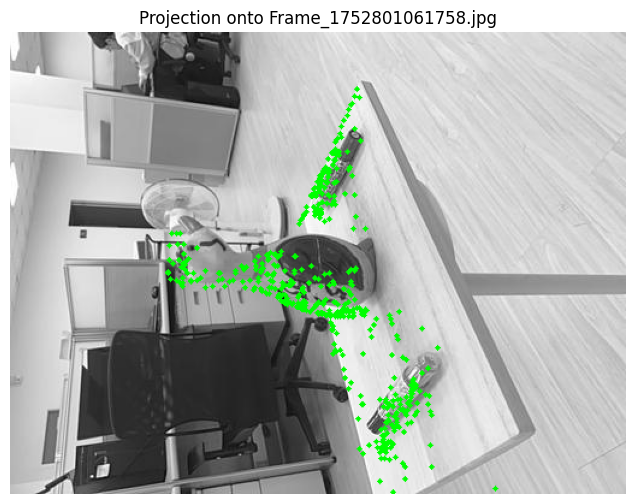

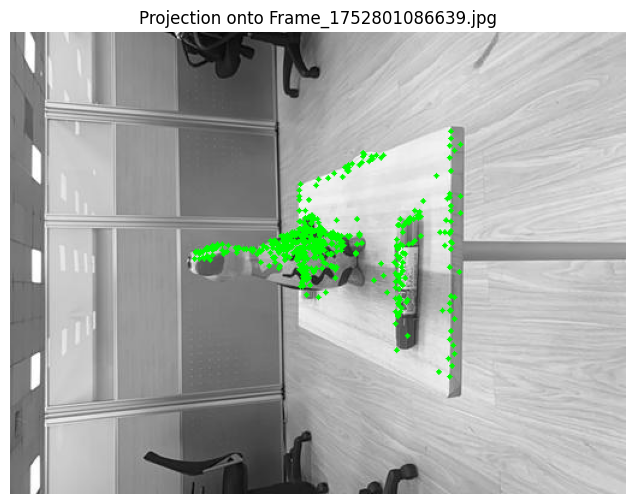

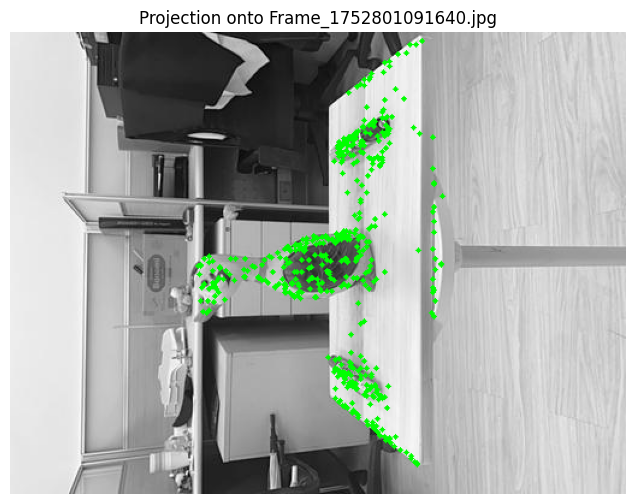

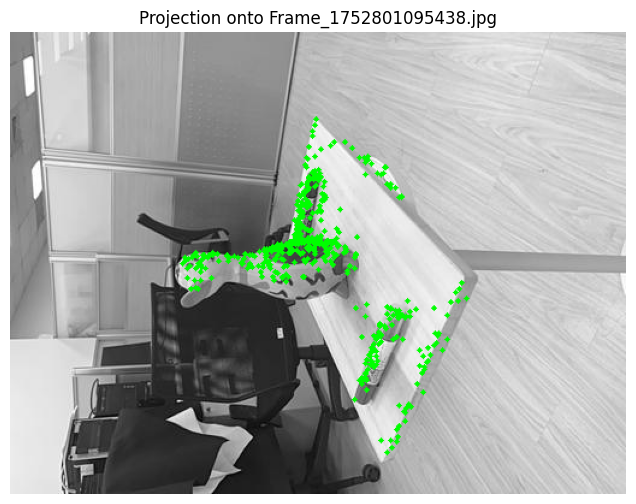

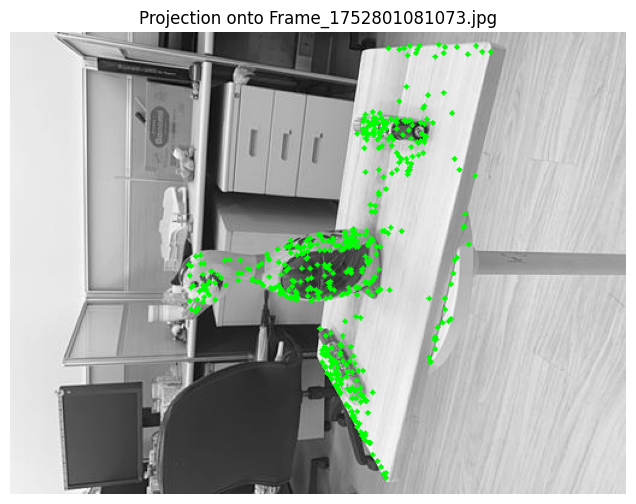

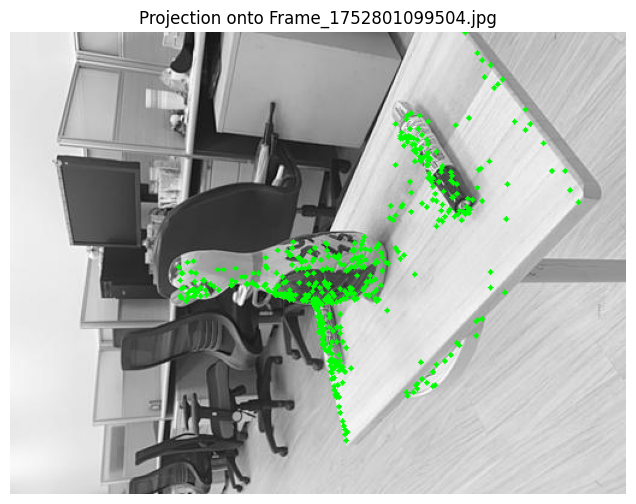

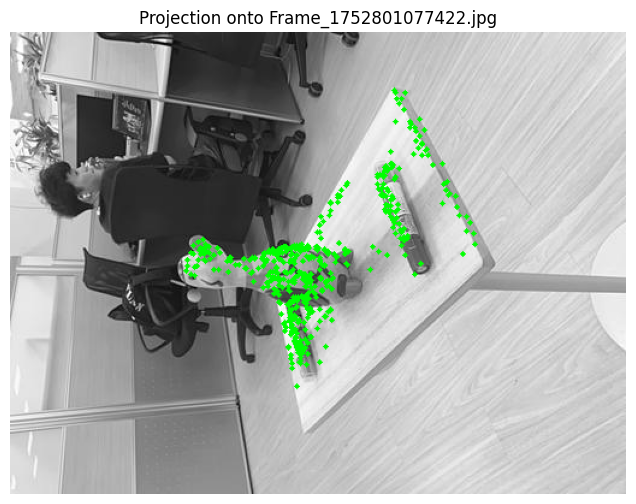

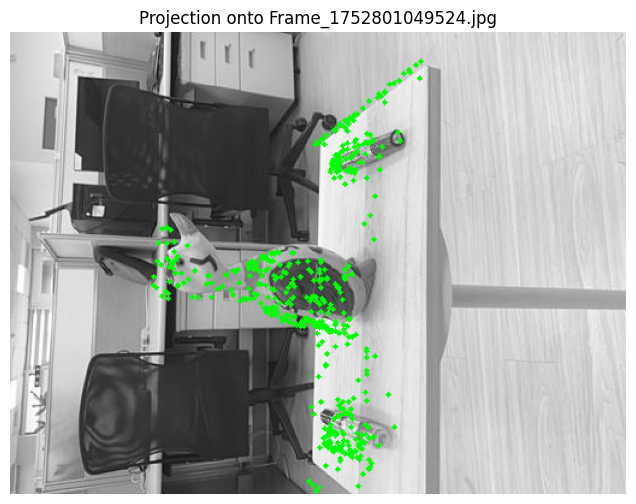

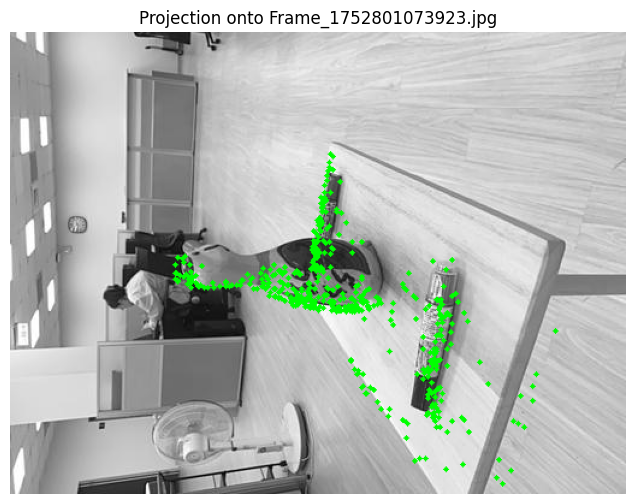

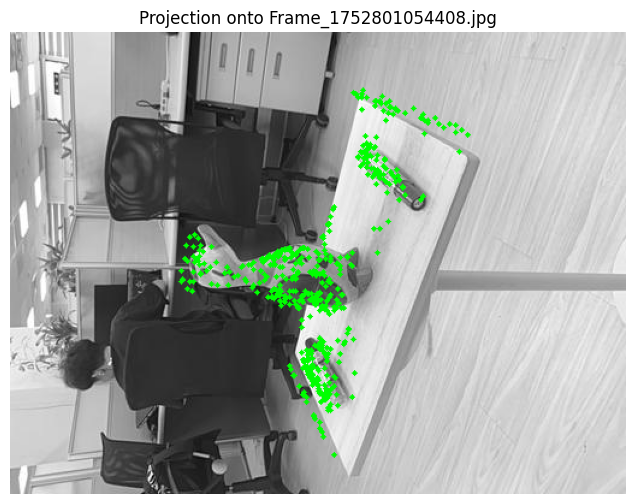

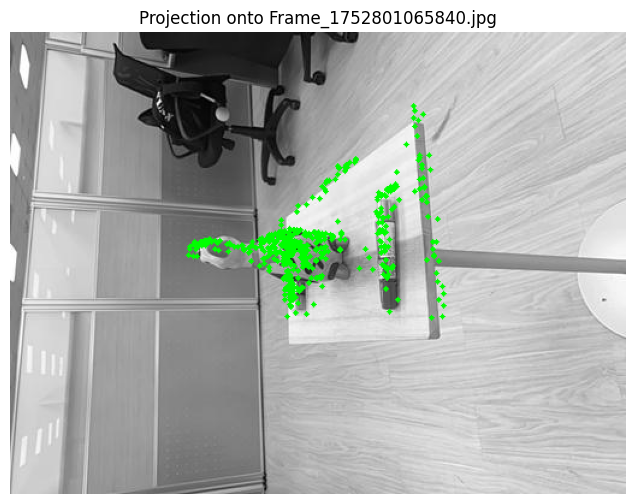

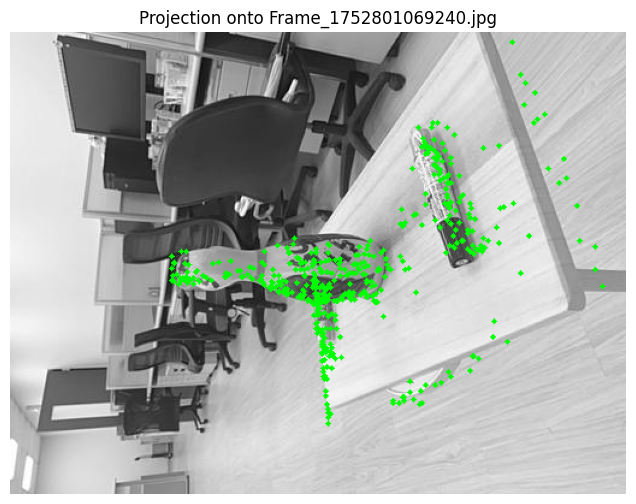

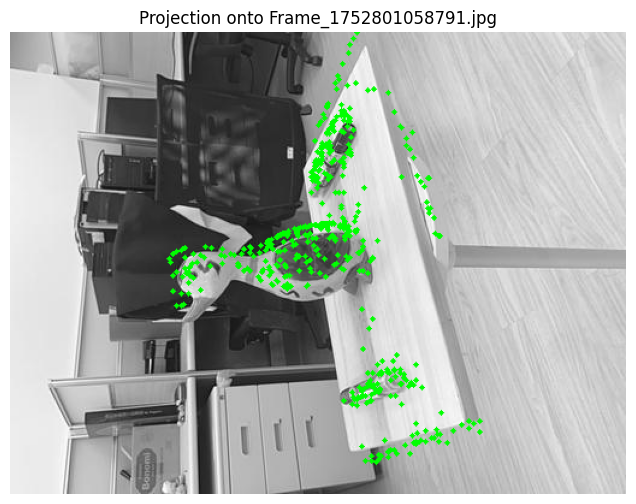

In [70]:
projected_pts = {}

for idx, name in enumerate(image_list):
    img_path = f"data/images/{name}"
    curr_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    pts_proj, _ = project_and_visualize_points(
        name=name,
        target_frame_idx=idx,
        extrinsic=extrinsic,
        intrinsics=intrinsics,
        pts3d=pts3d,
        image_shape=curr_img.shape,
        visualize=True
    )
    projected_pts[name] = pts_proj

In [71]:
name = 'Frame_1752801058791.jpg'
# print("pair :", pair)
origin_features = np.array([np.array(f, dtype=float) for (f, idx) in pair], dtype=float)
projected_features = projected_pts[name][:, :2]
# print(origin_features)
# print(projected_features)

In [72]:
def extract_patch(image, center, size=20):
    """
    從 image 中提取以 center 為中心的 patch（方形大小為 size×size）
    """
    x, y = int(center[0]), int(center[1])
    half = size // 2
    h, w = image.shape[:2]

    # 裁切邊界防呆
    xmin, xmax = max(0, x - half), min(w, x + half + 1)
    ymin, ymax = max(0, y - half), min(h, y + half + 1)

    patch = image[ymin:ymax, xmin:xmax]
    return patch


def compute_center_gradient_score(patch):
    """
    取以 pt 為中心的 patch，並回傳中心像素的梯度 magnitude 與 direction。
    """
    half = patch.shape[0] // 2
    grad_x = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)

    gx = grad_x[half, half]
    gy = grad_y[half, half]
    vec = np.array([gx, gy])
    norm = np.linalg.norm(vec)

    return vec / norm, norm

def compute_patch_gradient_similarity(patch1, patch2):
    """
    回傳兩個 patch 的梯度方向 cosine similarity。
    """
    grad_x1 = cv2.Sobel(patch1, cv2.CV_32F, 1, 0, ksize=3)
    grad_y1 = cv2.Sobel(patch1, cv2.CV_32F, 0, 1, ksize=3)
    grad_x2 = cv2.Sobel(patch2, cv2.CV_32F, 1, 0, ksize=3)
    grad_y2 = cv2.Sobel(patch2, cv2.CV_32F, 0, 1, ksize=3)

    vec1 = np.stack([grad_x1, grad_y1], axis=-1).reshape(-1, 2)
    vec2 = np.stack([grad_x2, grad_y2], axis=-1).reshape(-1, 2)

    # normalize vectors
    norm1 = np.linalg.norm(vec1, axis=1, keepdims=True) + 1e-8
    norm2 = np.linalg.norm(vec2, axis=1, keepdims=True) + 1e-8
    vec1_normalized = vec1 / norm1
    vec2_normalized = vec2 / norm2

    cosine_sim = np.sum(vec1_normalized * vec2_normalized, axis=1)
    return np.mean(cosine_sim)


def refine_match(
    img2_gray,
    projected_point,
    reference_patch,     # 灰階 patch
    patch_size=11,
    search_radius=5,
):
    """
    使用 patch 中心的 gradient 方向與強度，比較 cosine 相似度。
    """
    # baseline: 取得 reference patch 中心的 gradient 與 magnitude
    ref_dir, ref_mag = compute_center_gradient_score(reference_patch)
    if ref_dir is None:
        return projected_point

    best_score = -1
    best_pt = projected_point.copy()

    for dx in range(-search_radius, search_radius + 1):
        for dy in range(-search_radius, search_radius + 1):
            pt = projected_point + np.array([dx, dy])
            patch = extract_patch(img2_gray, pt, size=patch_size)
            if patch.shape != reference_patch.shape:
                continue

            tgt_dir, tgt_mag = compute_center_gradient_score(patch)
            if tgt_dir is None:
                continue

            # 比方向一致程度 + 對比強度（magnitude）
            direction_score = np.dot(ref_dir, tgt_dir)
            score = direction_score * tgt_mag

            # 可選：加入中心亮度比對，降低語意不符的 match
            ref_center_val = reference_patch[patch_size // 2, patch_size // 2]
            tgt_center_val = patch[patch_size // 2, patch_size // 2]
            brightness_diff = abs(float(ref_center_val) - float(tgt_center_val))
            brightness_penalty = np.exp(-brightness_diff / 50.0)

            score *= brightness_penalty

            grad_sim = compute_patch_gradient_similarity(reference_patch, patch)
            score *= (0.5 + 0.2 * grad_sim)  # 調整權重，可視情況微調

            if score > best_score:
                best_score = score
                best_pt = pt

    return best_pt

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def refine_and_visualize(
    img1,                     # keyframe 灰階圖
    img2,                     # target 灰階圖
    origin_features,          # keyframe 上的特徵點 (N, 2)
    projected_features,       # img2 上的投影點 (N, 2)
    patch_size=15,            # 描述子 & 顯示 patch 大小
    search_radius=20,         # refinement 搜尋範圍
    N=10,                      # 要可視化的前 N 點
    visualize=True  # 是否顯示全圖的向量箭頭
):
    # Step 1: Refinement
    refined_points = []
    for orig_pt, proj_pt in zip(origin_features, projected_features):
        desc1 = extract_patch(img1, orig_pt, size=patch_size)
        refined_pt = refine_match(img2, proj_pt, desc1, patch_size=patch_size, search_radius=search_radius)
        refined_points.append(refined_pt)
    refined_points = np.array(refined_points)

    if visualize:
        # Step 2: 可視化 patch + 標註位置
        plt.figure(figsize=(12, 5 * N))
        for i in range(N):
            orig_pt = origin_features[i]
            proj_pt = projected_features[i]
            refined_pt = refined_points[i]

            patch_orig = extract_patch(img1, orig_pt, size=patch_size)
            patch_proj = extract_patch(img2, proj_pt, size=patch_size)
            patch_refined = extract_patch(img2, refined_pt, size=patch_size)

           # 顯示 patch
            plt.subplot(N, 5, i * 5 + 1)
            plt.imshow(patch_orig, cmap='gray')
            plt.title(f'Original patch #{i}')
            plt.axis('off')

            plt.subplot(N, 5, i * 5 + 2)
            plt.imshow(patch_proj, cmap='gray')
            plt.title(f'Projected patch #{i}')
            plt.axis('off')

            plt.subplot(N, 5, i * 5 + 3)
            plt.imshow(patch_refined, cmap='gray')
            plt.title(f'Refined patch #{i}')
            plt.axis('off')


            # 原圖與目標圖的標註
            vis_img1 = img1.copy()
            vis_img2 = img2.copy()

            cv2.circle(vis_img1, tuple(np.int32(orig_pt)), 5, (0, 0, 255), -1)
            cv2.putText(vis_img1, str(i), tuple(np.int32(orig_pt + 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            cv2.circle(vis_img2, tuple(np.int32(proj_pt)), 5, (255, 0, 0), -1)
            cv2.circle(vis_img2, tuple(np.int32(refined_pt)), 5, (0, 255, 0), -1)
            cv2.putText(vis_img2, str(i), tuple(np.int32(refined_pt + 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            plt.subplot(N, 5, i * 5 + 4)
            plt.imshow(vis_img1, cmap='gray')
            plt.title(f'Keyframe #{i}')
            plt.axis('off')

            plt.subplot(N, 5, i * 5 + 5)
            plt.imshow(vis_img2, cmap='gray')
            plt.title(f'Projection #{i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Step 3: 全圖畫向量箭頭
        vis_img = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        for proj_pt, refined_pt in zip(projected_features, refined_points):
            p1 = tuple(np.round(proj_pt).astype(int))
            p2 = tuple(np.round(refined_pt).astype(int))
            cv2.circle(vis_img, p1, 2, (255, 0, 0), -1)
            cv2.circle(vis_img, p2, 2, (0, 255, 0), -1)
            cv2.line(vis_img, p1, p2, (0, 0, 255), 1)

        cv2.imshow("Refined Feature Matches", vis_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return refined_points


In [74]:
origin_features = projected_pts[key_frame_name][:, :2]
img_path = f"data/images/{name}"
img1 = cv2.imread(keyframe_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)


refined_points = refine_and_visualize(
    img1, img2,
    origin_features,
    projected_features,
    patch_size=25,
    search_radius=10,
    N=10,
    visualize=False
)

/tmp/ipykernel_1826899/1779997419.py:30: RuntimeWarning: invalid value encountered in divide
  return vec / norm, norm


In [75]:
import numpy as np

P = origin_features.shape[0]
N = len(image_list)

tracks = np.full((N, P, 2), np.nan, dtype=np.float32)


# 接下來每張圖的 refined_points 對應同一個 P
for i, image_name in enumerate(image_list):
    img_path = f"data/images/{image_name}"
    img2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    projected_features = projected_pts[image_name][:, :2]

    refined_points = refine_and_visualize(
        img1, img2,
        origin_features,
        projected_features,
        patch_size=25,
        search_radius=10,
        N=5,
        visualize=False
    )
    tracks[i] = refined_points  # +1 是因為 0 是 keyframe


/tmp/ipykernel_1826899/1779997419.py:30: RuntimeWarning: invalid value encountered in divide
  return vec / norm, norm


In [76]:
def apply_distortion(extra_params, u, v):
    """
    Applies radial or OpenCV distortion to the given 2D points.

    Args:
        extra_params (torch.Tensor or numpy.ndarray): Distortion parameters of shape BxN, where N can be 1, 2, or 4.
        u (torch.Tensor or numpy.ndarray): Normalized x coordinates of shape Bxnum_tracks.
        v (torch.Tensor or numpy.ndarray): Normalized y coordinates of shape Bxnum_tracks.

    Returns:
        points2D (torch.Tensor): Distorted 2D points of shape BxNx2.
    """
    extra_params = _ensure_torch(extra_params)
    u = _ensure_torch(u)
    v = _ensure_torch(v)

    num_params = extra_params.shape[1]

    if num_params == 1:
        # Simple radial distortion
        k = extra_params[:, 0]
        u2 = u * u
        v2 = v * v
        r2 = u2 + v2
        radial = k[:, None] * r2
        du = u * radial
        dv = v * radial

    elif num_params == 2:
        # RadialCameraModel distortion
        k1, k2 = extra_params[:, 0], extra_params[:, 1]
        u2 = u * u
        v2 = v * v
        r2 = u2 + v2
        radial = k1[:, None] * r2 + k2[:, None] * r2 * r2
        du = u * radial
        dv = v * radial

    elif num_params == 4:
        # OpenCVCameraModel distortion
        k1, k2, p1, p2 = (extra_params[:, 0], extra_params[:, 1], extra_params[:, 2], extra_params[:, 3])
        u2 = u * u
        v2 = v * v
        uv = u * v
        r2 = u2 + v2
        radial = k1[:, None] * r2 + k2[:, None] * r2 * r2
        du = u * radial + 2 * p1[:, None] * uv + p2[:, None] * (r2 + 2 * u2)
        dv = v * radial + 2 * p2[:, None] * uv + p1[:, None] * (r2 + 2 * v2)
    else:
        raise ValueError("Unsupported number of distortion parameters")

    u = u.clone() + du
    v = v.clone() + dv

    return u, v

def img_from_cam_np(
    intrinsics: np.ndarray, points_cam: np.ndarray, extra_params: np.ndarray | None = None, default: float = 0.0
) -> np.ndarray:
    """
    Apply intrinsics (and optional radial distortion) to camera-space points.

    Args
    ----
    intrinsics  : (B,3,3) camera matrix K.
    points_cam  : (B,3,N) homogeneous camera coords  (x, y, z)ᵀ.
    extra_params: (B, N) or (B, k) distortion params (k = 1,2,4) or None.
    default     : value used for np.nan replacement.

    Returns
    -------
    points2D : (B,N,2) pixel coordinates.
    """
    # 1. perspective divide  ───────────────────────────────────────
    z = points_cam[:, 2:3, :]  # (B,1,N)
    points_cam_norm = points_cam / z  # (B,3,N)
    uv = points_cam_norm[:, :2, :]  # (B,2,N)

    # 2. optional distortion ──────────────────────────────────────
    if extra_params is not None:
        uu, vv = apply_distortion(extra_params, uv[:, 0], uv[:, 1])
        uv = np.stack([uu, vv], axis=1)  # (B,2,N)

    # 3. homogeneous coords then K multiplication ─────────────────
    ones = np.ones_like(uv[:, :1, :])  # (B,1,N)
    points_cam_h = np.concatenate([uv, ones], axis=1)  # (B,3,N)

    # batched mat-mul: K · [u v 1]ᵀ
    points2D_h = np.einsum("bij,bjk->bik", intrinsics, points_cam_h)  # (B,3,N)
    points2D = np.nan_to_num(points2D_h[:, :2, :], nan=default)  # (B,2,N)

    return points2D.transpose(0, 2, 1)  # (B,N,2)

In [77]:
def project_3D_points_np(
    points3D: np.ndarray,
    extrinsics: np.ndarray,
    intrinsics: np.ndarray | None = None,
    extra_params: np.ndarray | None = None,
    *,
    default: float = 0.0,
    only_points_cam: bool = False,
):
    """
    NumPy clone of ``project_3D_points``.

    Parameters
    ----------
    points3D          : (N,3) world-space points.
    extrinsics        : (B,3,4)  [R|t] matrix for each of B cameras.
    intrinsics        : (B,3,3)  K matrix (optional if you only need cam-space).
    extra_params      : (B,k) or (B,N) distortion parameters (k ∈ {1,2,4}) or None.
    default           : value used to replace NaNs.
    only_points_cam   : if True, skip the projection and return points_cam with points2D as None.

    Returns
    -------
    (points2D, points_cam) : A tuple where points2D is (B,N,2) pixel coords or None if only_points_cam=True,
                           and points_cam is (B,3,N) camera-space coordinates.
    """
    # ----- 0. prep sizes -----------------------------------------------------
    N = points3D.shape[0]  # #points
    B = extrinsics.shape[0]  # #cameras

    # ----- 1. world → homogeneous -------------------------------------------
    w_h = np.ones((N, 1), dtype=points3D.dtype)
    points3D_h = np.concatenate([points3D, w_h], axis=1)  # (N,4)

    # broadcast to every camera (no actual copying with np.broadcast_to) ------
    points3D_h_B = np.broadcast_to(points3D_h, (B, N, 4))  # (B,N,4)

    # ----- 2. apply extrinsics  (camera frame) ------------------------------
    # X_cam = E · X_hom
    # einsum:  E_(b i j)  ·  X_(b n j)  →  (b n i)
    points_cam = np.einsum("bij,bnj->bni", extrinsics, points3D_h_B)  # (B,N,3)
    points_cam = points_cam.transpose(0, 2, 1)  # (B,3,N)

    if only_points_cam:
        return None, points_cam

    # ----- 3. intrinsics + distortion ---------------------------------------
    if intrinsics is None:
        raise ValueError("`intrinsics` must be provided unless only_points_cam=True")

    points2D = img_from_cam_np(intrinsics, points_cam, extra_params=extra_params, default=default)

    return points2D, points_cam


def _build_pycolmap_intri(fidx, intrinsics, camera_type, extra_params=None):
    """
    Helper function to get camera parameters based on camera type.

    Args:
        fidx: Frame index
        intrinsics: Camera intrinsic parameters
        camera_type: Type of camera model
        extra_params: Additional parameters for certain camera types

    Returns:
        pycolmap_intri: NumPy array of camera parameters
    """
    if camera_type == "PINHOLE":
        pycolmap_intri = np.array(
            [intrinsics[fidx][0, 0], intrinsics[fidx][1, 1], intrinsics[fidx][0, 2], intrinsics[fidx][1, 2]]
        )
    elif camera_type == "SIMPLE_PINHOLE":
        focal = (intrinsics[fidx][0, 0] + intrinsics[fidx][1, 1]) / 2
        pycolmap_intri = np.array([focal, intrinsics[fidx][0, 2], intrinsics[fidx][1, 2]])
    elif camera_type == "SIMPLE_RADIAL":
        raise NotImplementedError("SIMPLE_RADIAL is not supported yet")
        focal = (intrinsics[fidx][0, 0] + intrinsics[fidx][1, 1]) / 2
        pycolmap_intri = np.array([focal, intrinsics[fidx][0, 2], intrinsics[fidx][1, 2], extra_params[fidx][0]])
    else:
        raise ValueError(f"Camera type {camera_type} is not supported yet")

    return pycolmap_intri


In [78]:
def batch_np_matrix_to_pycolmap(
    points3d,
    extrinsics,
    intrinsics,
    tracks,
    image_size,
    masks=None,
    max_reproj_error=None,
    max_points3D_val=3000,
    shared_camera=False,
    camera_type="SIMPLE_PINHOLE",
    extra_params=None,
    min_inlier_per_frame=64,
    image_list=None,
    points_rgb=None,
):
    """
    Convert Batched NumPy Arrays to PyCOLMAP

    Check https://github.com/colmap/pycolmap for more details about its format

    NOTE that colmap expects images/cameras/points3D to be 1-indexed
    so there is a +1 offset between colmap index and batch index


    NOTE: different from VGGSfM, this function:
    1. Use np instead of torch
    2. Frame index and camera id starts from 1 rather than 0 (to fit the format of PyCOLMAP)
    """
    # points3d: Px3
    # extrinsics: Nx3x4
    # intrinsics: Nx3x3
    # tracks: NxPx2
    # masks: NxP
    # image_size: 2, assume all the frames have been padded to the same size
    # where N is the number of frames and P is the number of tracks

    N, P, _ = tracks.shape
    assert len(extrinsics) == N
    assert len(intrinsics) == N
    assert len(points3d) == P
    assert image_size.shape[0] == 2

    reproj_mask = None

    if max_reproj_error is not None:
        projected_points_2d, projected_points_cam = project_3D_points_np(points3d, extrinsics, intrinsics)
        projected_diff = np.linalg.norm(projected_points_2d - tracks, axis=-1)
        projected_points_2d[projected_points_cam[:, -1] <= 0] = 1e6
        reproj_mask = projected_diff < max_reproj_error

    if masks is not None and reproj_mask is not None:
        masks = np.logical_and(masks, reproj_mask)
    elif masks is not None:
        masks = masks
    else:
        masks = reproj_mask

    assert masks is not None

    inliers_per_frame = masks.sum(1)
    print(f"[DEBUG] Final inliers per frame: {inliers_per_frame}")
    print(f"[DEBUG] Min inliers per frame: {inliers_per_frame.min()}, Max: {inliers_per_frame.max()}")

    if inliers_per_frame.min() < min_inlier_per_frame:
        print(f"[WARNING] Some frames have < {min_inlier_per_frame} inliers, skip BA.")
        return None, None


    # Reconstruction object, following the format of PyCOLMAP/COLMAP
    reconstruction = pycolmap.Reconstruction()

    inlier_num = masks.sum(0)
    valid_mask = inlier_num >= 2  # a track is invalid if without two inliers
    valid_idx = np.nonzero(valid_mask)[0]

    # Only add 3D points that have sufficient 2D points
    for vidx in valid_idx:
        pt = np.asarray(points3d[vidx], dtype=np.float64).reshape(3)
        rgb = np.asarray(points_rgb[vidx], dtype=np.uint8).reshape(3)
        pt = np.ascontiguousarray(pt)
        rgb = np.ascontiguousarray(rgb)
        track = pycolmap.Track()
        reconstruction.add_point3D(pt, track, rgb)


    num_points3D = len(valid_idx)
    camera = None
    # frame idx
    for fidx in range(N):
        # set camera
        if camera is None or (not shared_camera):
            pycolmap_intri = _build_pycolmap_intri(fidx, intrinsics, camera_type, extra_params)

            camera = pycolmap.Camera(
                model=camera_type, width=image_size[0], height=image_size[1], params=pycolmap_intri, camera_id=fidx + 1
            )

            # add camera
            reconstruction.add_camera(camera)

        # set image
        cam_from_world = pycolmap.Rigid3d(
            pycolmap.Rotation3d(extrinsics[fidx][:3, :3]), extrinsics[fidx][:3, 3]
        )  # Rot and Trans

        image = pycolmap.Image(
            id=fidx + 1, name=image_list[fidx], camera_id=camera.camera_id, cam_from_world=cam_from_world
        )

        points2D_list = []

        point2D_idx = 0

        # NOTE point3D_id start by 1
        for point3D_id in range(1, num_points3D + 1):
            original_track_idx = valid_idx[point3D_id - 1]

            if (reconstruction.points3D[point3D_id].xyz < max_points3D_val).all():
                if masks[fidx][original_track_idx]:
                    # It seems we don't need +0.5 for BA
                    point2D_xy = tracks[fidx][original_track_idx]
                    # Please note when adding the Point2D object
                    # It not only requires the 2D xy location, but also the id to 3D point
                    points2D_list.append(pycolmap.Point2D(point2D_xy, point3D_id))

                    # add element
                    track = reconstruction.points3D[point3D_id].track
                    track.add_element(fidx + 1, point2D_idx)
                    point2D_idx += 1

        assert point2D_idx == len(points2D_list)

        try:
            image.points2D = pycolmap.ListPoint2D(points2D_list)
            image.registered = True
        except:
            print(f"frame {fidx + 1} is out of BA")
            image.registered = False

        # add image
        reconstruction.add_image(image)

    return reconstruction, valid_mask



In [80]:
key_frame_idx = 0
key_frame_name = image_list[key_frame_idx]  # e.g., "0001.jpg"

# 讀 keyframe 的 RGB 圖片
img_path = f"data/images/{key_frame_name}"
key_img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)
if key_img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

# 取得顏色
_, points_rgb_bgr = project_and_visualize_points(
    name=key_frame_name,
    target_frame_idx=key_frame_idx,
    extrinsic=extrinsic,
    intrinsics=intrinsics,
    pts3d=pts3d,
    image_shape=key_img.shape[:2],
    visualize=False,
    color_image=key_img  # 傳入 RGB 圖片
)

# 注意：轉換為 RGB（如果不是的話）
points_rgb = points_rgb_bgr  # 已經在 function 中轉成 RGB
image_size = np.array(img1.shape[::-1])  # (W, H)
extrinsics_array = np.stack([np.hstack((R, t.reshape(-1, 1))) for (R, t) in extrinsic])
intrinsics_array = np.stack(intrinsics)



In [81]:
# print(intrinsics)

In [82]:
print(len(extrinsic), len(intrinsics), tracks.shape)

13 13 (13, 500, 2)


In [83]:
import pycolmap

reconstruction, valid_track_mask = batch_np_matrix_to_pycolmap(
    pts3d,
    extrinsics_array,
    intrinsics_array,
    tracks,
    image_size,
    masks=None,
    max_reproj_error=20,
    shared_camera=False,
    camera_type="SIMPLE_PINHOLE",
    image_list=image_list,
    points_rgb=points_rgb,
)

if reconstruction is None:
    raise ValueError("No reconstruction can be built with BA")

print("fininshed building pycolmap reconstruction")
# # Bundle Adjustment
# ba_options = pycolmap.BundleAdjustmentOptions()
# pycolmap.bundle_adjustment(reconstruction, ba_options)

[DEBUG] Final inliers per frame: [500 500 500 500 500 500 500 500 500 500 500 500 500]
[DEBUG] Min inliers per frame: 500, Max: 500
fininshed building pycolmap reconstruction


In [84]:
ba_options = pycolmap.BundleAdjustmentOptions()
pycolmap.bundle_adjustment(reconstruction, ba_options)

I20250910 10:31:19.436090 126109591463744 misc.cc:198] 
Global bundle adjustment
I20250910 10:31:19.961127 126109591463744 bundle_adjustment.cc:866] 
Bundle adjustment report:
    Residuals : 13000
   Parameters : 1584
   Iterations : 22
         Time : 0.518687 [s]
 Initial cost : 4.37723 [px]
   Final cost : 3.82367 [px]
  Termination : Convergence

I20250910 10:31:19.961155 126109591463744 timer.cc:91] Elapsed time: 0.009 [minutes]


In [85]:
output_dir = "results/sparse/0"
reconstruction.write(output_dir)
